In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import interactive, widgets
from IPython.display import display
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import MFKSFVEvolve as fv
from utils import reparameterize


/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# evolve a given P for some steps 
n_grid = 50
fact = 1

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-1
r = 1e-4

lbd_spl = 12.0

kappa, k, eps, _lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)

lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')

cell_boundaries, dx_array, cell_centers = fv.prepare_grid(lbd_spl, n_grid, fact)
rmat = fv.rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, n_grid)
g_int_array = fv.g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

# high sigma ini
P_ini = 1 * np.exp( - (cell_centers - 0.85 * lbd_spl)**2 / 5**2) 
# low sigma ini
# P_ini = 1 * np.exp( - (cell_centers - 0.85 * lbd_spl)**2 / 0.3**2) 

num_frames = 1000
dt = 0.1
stride = 1

P, stats = fv.evolve_P(num_frames, stride, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=True)

Emerging scales: lbd_spl/2 = 6.00, lbd_max = 13.58, lbd_spl = 12.00


Evolving P : 100%|██████████| 1000/1000 [00:00<00:00, 2068.79it/s]


Emerging scales: lbd_spl/2 = 6.00, lbd_max = 13.58, lbd_spl = 12.00


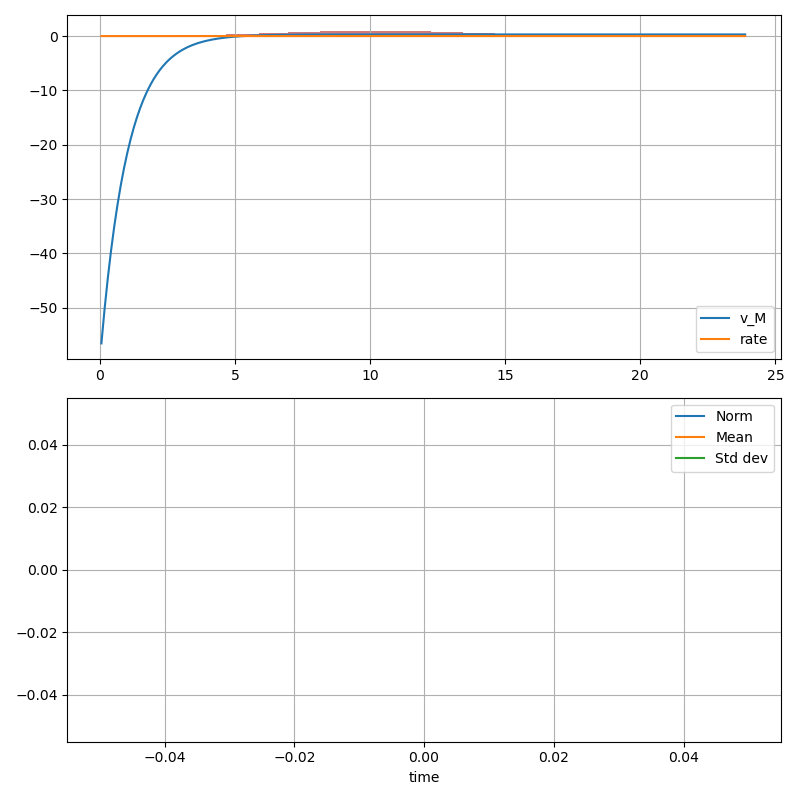

In [2]:
# evolve a given P for some steps (animated plot)
n_grid = 50
fact = 1

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-1
r = 1e-4

lbd_spl = 12.0

kappa, k, eps, _lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)

lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')

cell_boundaries, dx_array, cell_centers = fv.prepare_grid(lbd_spl, n_grid, fact)
rmat = fv.rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, n_grid)
g_int_array = fv.g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

# high sigma ini
P_ini = 1 * np.exp( - (cell_centers - 0.85 * lbd_spl)**2 / 5**2) 
# low sigma ini
# P_ini = 1 * np.exp( - (cell_centers - 0.85 * lbd_spl)**2 / 0.3**2) 

num_frames = 1000
dt = 0.1
stride = 1000
# final time = num_frames * stride * dt

# Initial state
P = P_ini

# Initialize plot
plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
ax1 = axs[0]
bars = ax1.bar(cell_centers, P_ini, width=dx_array, color='firebrick', alpha=0.6)
vM_scale_fact = 0.3 / np.max(fv.v_M(cell_centers, P_ini, g_int_array, dx_array, kappa, k, eps))
vM_line, = ax1.plot(cell_centers, vM_scale_fact * fv.v_M(cell_centers, P_ini, g_int_array, dx_array, kappa, k, eps), label='v_M')
ax1.plot(cell_centers, r * np.maximum(0, cell_centers - lbd_spl), label='rate')
time_text = ax1.text(0.02, 0.93, '', transform=ax1.transAxes)
ax1.legend()
ax1.grid()

# Variables to store statistics over time
times = []
stats1 = []
stats2 = []
stats3 = []

# Initialize second plot
ax2 = axs[1]
m0_line, = ax2.plot([], [], label='Norm')
m1_line, = ax2.plot([], [], label='Mean')
m2_line, = ax2.plot([], [], label='Std dev')
ax2.set_xlabel('time')
ax2.legend()
ax2.grid()

# Update function for animation
t = 0
frame = 1
def update(frame):
    global P, t, times, stats1, stats2, stats3
    _stride = stride #if frame > 0 else 1
    t += _stride * dt
    P, stats = fv.evolve_P(_stride, _stride, P, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=False)
    
    # Update the bar heights
    for bar, height in zip(bars, P):
        bar.set_height(height)
    
    # Update vM line
    vM_line.set_ydata(vM_scale_fact * fv.v_M(cell_centers, P, g_int_array, dx_array, kappa, k, eps))
    
    # Update text annotations
    time_text.set_text(f'Time: {t:.3e} / {(dt * num_frames * stride):.2e}')
    
    # Append new statistics
    times.append(t)
    stats1.append(stats[0,0])  # Assuming stats returns a list/array of statistics
    stats2.append(stats[1,0])
    stats3.append(stats[2,0])
    
    # Update statistics plots
    m0_line.set_data(times, stats1)
    m1_line.set_data(times, stats2)
    m2_line.set_data(times, stats3)
    
    ax1.set_xlim(0, np.max(cell_boundaries))
    ax1.set_ylim(-0.3, 0.5)
    
    ax2.relim()
    ax2.autoscale_view()

    return bars, vM_line, time_text, m0_line, m1_line, m2_line

# Create animation
ani = FuncAnimation(fig, update, frames=num_frames, blit=True, repeat=False, interval=1)
# ani.save('works5.gif')

# Display animation
plt.tight_layout()
plt.show()


In [12]:
plt.close('all')

Emerging scales: lbd_spl/2 = 6.00, lbd_max = 13.58, lbd_spl = 12.00


Evolving P : 100%|██████████| 1000000/1000000 [00:36<00:00, 27490.67it/s]


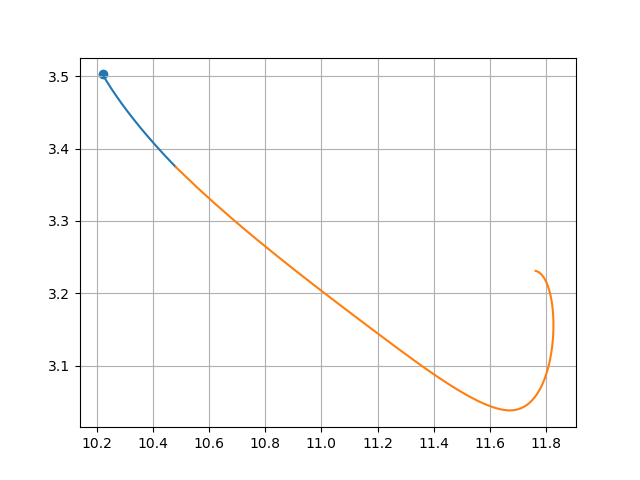

In [4]:
# evolve a given P for longer times: first precondition shortly, then speed up. Plot only stats 
n_grid = 50
fact = 1

Drho = 0.1
Dc = 1.0
T = 5.0
epsilon = 1e-1
r = 1e-4

lbd_spl = 12.0

kappa, k, eps, _lbd_spl, r = reparameterize(Drho, Dc, T, epsilon, r)

lbd_max = -1 / k * np.log(eps / k / kappa)
print(f'Emerging scales: {lbd_spl/2 = :.2f}, {lbd_max = :.2f}, {lbd_spl = :.2f}')

cell_boundaries, dx_array, cell_centers = fv.prepare_grid(lbd_spl, n_grid, fact)
rmat = fv.rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, n_grid)
g_int_array = fv.g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

# high sigma ini
P_ini = 1 * np.exp( - (cell_centers - 0.85 * lbd_spl)**2 / 5**2) 
# low sigma ini
# P_ini = 1 * np.exp( - (cell_centers - 0.85 * lbd_spl)**2 / 0.3**2) 

    
# precondition
n_steps = 2000
dt = 1e-2
stride = 1

P1, stats0 = fv.evolve_P(n_steps, stride, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=True, description='Preconditioning')
    
# evolve faster
n_steps = 1000000
dt = 1e-2
stride = 1000

P, stats = fv.evolve_P(n_steps, stride, P1, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat, tqdm_bool=True)

fig, ax = plt.subplots()    
ax.plot(stats0[1, :], stats0[2, :])
ax.plot(stats[1, :], stats[2, :])
ax.scatter(stats0[1, 0], stats0[2, 0])
ax.grid()
plt.show()

In [103]:
# evolve from gauss initial condition (helper function) many parameter sets
n_grid = 25
fact = 1

Drho = 0.1
Dc = 1.0
T = 5.0

n_epsilon = 3
epsilon_range = np.logspace(-2, 0, n_epsilon, endpoint=True)

r = 1e-4

n_lbd_spl = 2
lbd_spl_range = np.linspace(12, 30, n_lbd_spl)

params_list = [(Drho, Dc, T, epsilon, r, lbd_spl) for lbd_spl in lbd_spl_range for epsilon in epsilon_range]

n_mu = 1
n_sig = 2
ini_cond_list = [(_mu_fact, _sig) for _sig in np.linspace(0.3, 5.0, n_sig, endpoint=True) for _mu_fact in np.linspace(0.7, 0.9, n_mu, endpoint=True)]

n_steps = 1000000
dt = 1e-1
stride = 1000

results = np.empty((len(params_list), len(ini_cond_list), 2), dtype=object)

for i, params in tqdm(enumerate(params_list)):
    Drho, Dc, T, epsilon, r, lbd_spl = params
    kappa, k, eps, _, r = reparameterize(Drho, Dc, T, epsilon, r)

    for j, ini_cond in enumerate(ini_cond_list):
        mu_fact, sig = ini_cond
        mu = mu_fact * lbd_spl
        P_final, stats = fv.evolve_P_from_gauss(n_steps, stride, dt, n_grid, fact, kappa, k, eps, lbd_spl, r, mu, sig)
        results[i, j, 0] = P_final
        results[i, j, 1] = stats

Evolving P : 100%|██████████| 1000/1000 [00:00<00:00, 11034.56it/s]


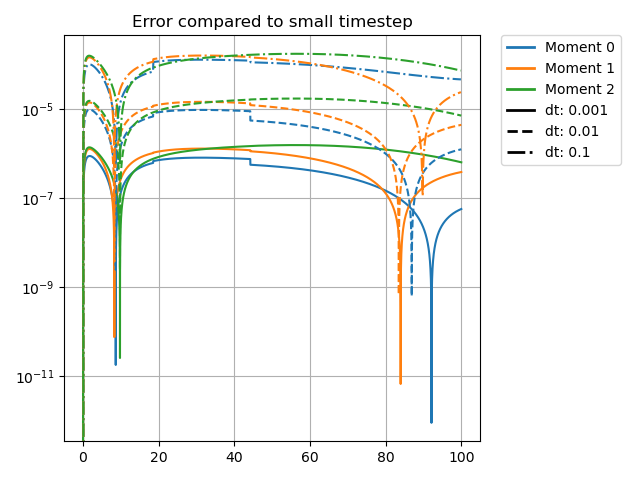

In [9]:
# show effect of timesteps 
from matplotlib.lines import Line2D
N = 20
lbd_spl = 7.5
fact = 1
cell_boundaries, dx_array, cell_centers = fv.prepare_grid(lbd_spl, N, fact)

r = 0.03
rmat = fv.rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, N)

kappa = 1.2
k = 1.2
eps = 0.0

g_int_array = fv.g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

P_ini = 1 * np.exp( - (cell_centers - 0.75 * lbd_spl)**2 / 2.3**2)

fig, ax = plt.subplots()

# prepare  
t_final = 100

# baseline
n_steps = 1000000
dt = t_final / n_steps
_, stats_full = fv.evolve_P(n_steps, 1, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat)

colors = ['C0', 'C1', 'C2']
line_styles = ['-', '--', '-.', ':']

n_stepss = [100000, 10000, 1000]
for ls_ind, n_steps in enumerate(n_stepss):
    dt = t_final / n_steps
    t_array = np.arange(n_steps)*dt 

    _, stats = fv.evolve_P(n_steps, 1, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat)
    for i in [0, 1, 2]:
        ax.plot(t_array, np.abs(stats[i,:] - stats_full[i, ::10**(1 + ls_ind)]), color=colors[i], linestyle=line_styles[ls_ind], label=f"moment = {i}, {dt = }")

# Create custom legend handles
color_handles = [Line2D([0], [0], color=colors[i], lw=2, label=f'Moment {i}') for i in range(3)]
style_handles = [Line2D([0], [0], color='k', linestyle=line_styles[i], lw=2, label=f'dt: {t_final / n_stepss[i]}') for i in range(len(n_stepss))]

# Add legend
ax.legend(handles=color_handles + style_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_title('Error compared to small timestep')
ax.grid()
ax.set_yscale('log')
plt.tight_layout()
plt.show()

Evolving P : 100%|██████████| 100000/100000 [00:00<00:00, 251235.36it/s]


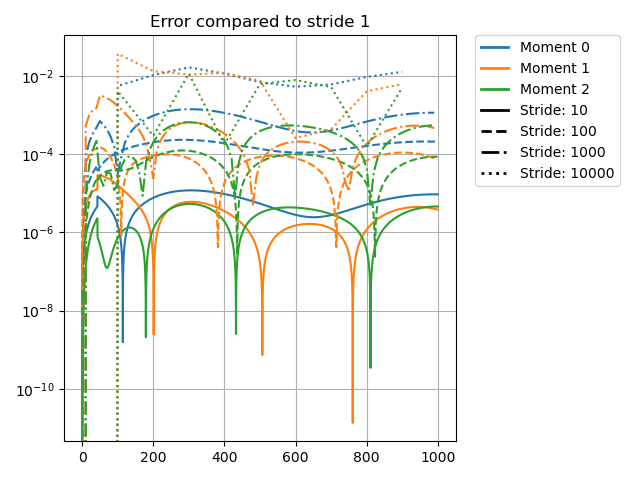

In [10]:
# show effect of stride 
from matplotlib.lines import Line2D
N = 20
lbd_spl = 7.5
fact = 1
cell_boundaries, dx_array, cell_centers = fv.prepare_grid(lbd_spl, N, fact)

r = 0.03
rmat = fv.rate_matrix(cell_boundaries, dx_array, cell_centers, lbd_spl, r, N)

kappa = 1.2
k = 1.2
eps = 0.0

g_int_array = fv.g_int(cell_boundaries, dx_array, cell_centers, kappa, k, eps)

P_ini = 1 * np.exp( - (cell_centers - 0.75 * lbd_spl)**2 / 2.3**2)

fig, ax = plt.subplots()

# prepare
n_steps = 10000
dt = 1e-2
P_first, _ = fv.evolve_P(n_steps, 1, P_ini, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat)
    
n_steps = 100000
dt = 1e-2
t_array = np.arange(n_steps)*dt 

colors = ['C0', 'C1', 'C2']
line_styles = ['-', '--', '-.', ':']

_, stats_full = fv.evolve_P(n_steps, 1, P_first, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat)

strides = [10, 100, 1000, 10000]
for ls_ind, stride in enumerate(strides):
    _, stats = fv.evolve_P(n_steps, stride, P_first, dt, cell_boundaries, dx_array, cell_centers, g_int_array, kappa, k, eps, rmat)
    for i in [0, 1, 2]:
        ax.plot(t_array[::stride], np.abs(stats[i,:] - stats_full[i, ::stride]), color=colors[i], linestyle=line_styles[ls_ind], label=f"moment = {i}, {stride = }")

# Create custom legend handles
color_handles = [Line2D([0], [0], color=colors[i], lw=2, label=f'Moment {i}') for i in range(3)]
style_handles = [Line2D([0], [0], color='k', linestyle=line_styles[i], lw=2, label=f'Stride: {strides[i]}') for i in range(len(strides))]

# Add legend
ax.legend(handles=color_handles + style_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

ax.set_title('Error compared to stride 1')
ax.grid()
ax.set_yscale('log')
plt.tight_layout()
plt.show()